# Cluster the data 

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read('/storage/users/data/PANC/H5AD_file/adata_filtered.h5ad')


In [3]:
adata

AnnData object with n_obs × n_vars = 8653 × 26333
    obs: 'condition', 'pct_cmo', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'doublet_scores', 'predicted_doublets', 'outlier', 'leiden'
    var: 'CMO', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_symbol', 'ensembl_gene_id', 'mito', 'ribo', 'n_cells'
    uns: 'condition_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

## Cluster the data (optional)

### Calculate clustering

In [4]:
# prepre clustering
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver="arpack") # PCA
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # Neighborhood Graph Construction

/home/job37yv/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Leiden Clustering
sc.tl.umap(adata)
sc.tl.leiden(adata)

/tmp/ipykernel_113401/3459005442.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


### Visualize clustering

In [6]:
!pwd

/storage/users/job37yv/Projects/single-cell_samantha/code/scripts_praktikum


In [7]:
adata.obs['condition']

barcode
AAACCCAGTAGGCTCC-1         CTRL_1
AAACCCAGTCGCAACC-1         CTRL_1
AAACCCATCCACAAGT-1         CTRL_1
AAACGCTTCACTACGA-1         CTRL_1
AAAGAACAGATACAGT-1         CTRL_1
                         ...     
TTTACTGCAGCTACAT-1    TGFb1_GEM_2
TTTCACAGTGATATAG-1    TGFb1_GEM_2
TTTCACATCGATGCAT-1    TGFb1_GEM_2
TTTCATGTCCCTCTAG-1    TGFb1_GEM_2
TTTGACTGTTCCGGTG-1    TGFb1_GEM_2
Name: condition, Length: 8653, dtype: category
Categories (8, object): ['CTRL_1', 'CTRL_2', 'CTRL_2D', 'GEM_2', 'TGFb1_1', 'TGFb1_2', 'TGFb1_GEM_1', 'TGFb1_GEM_2']

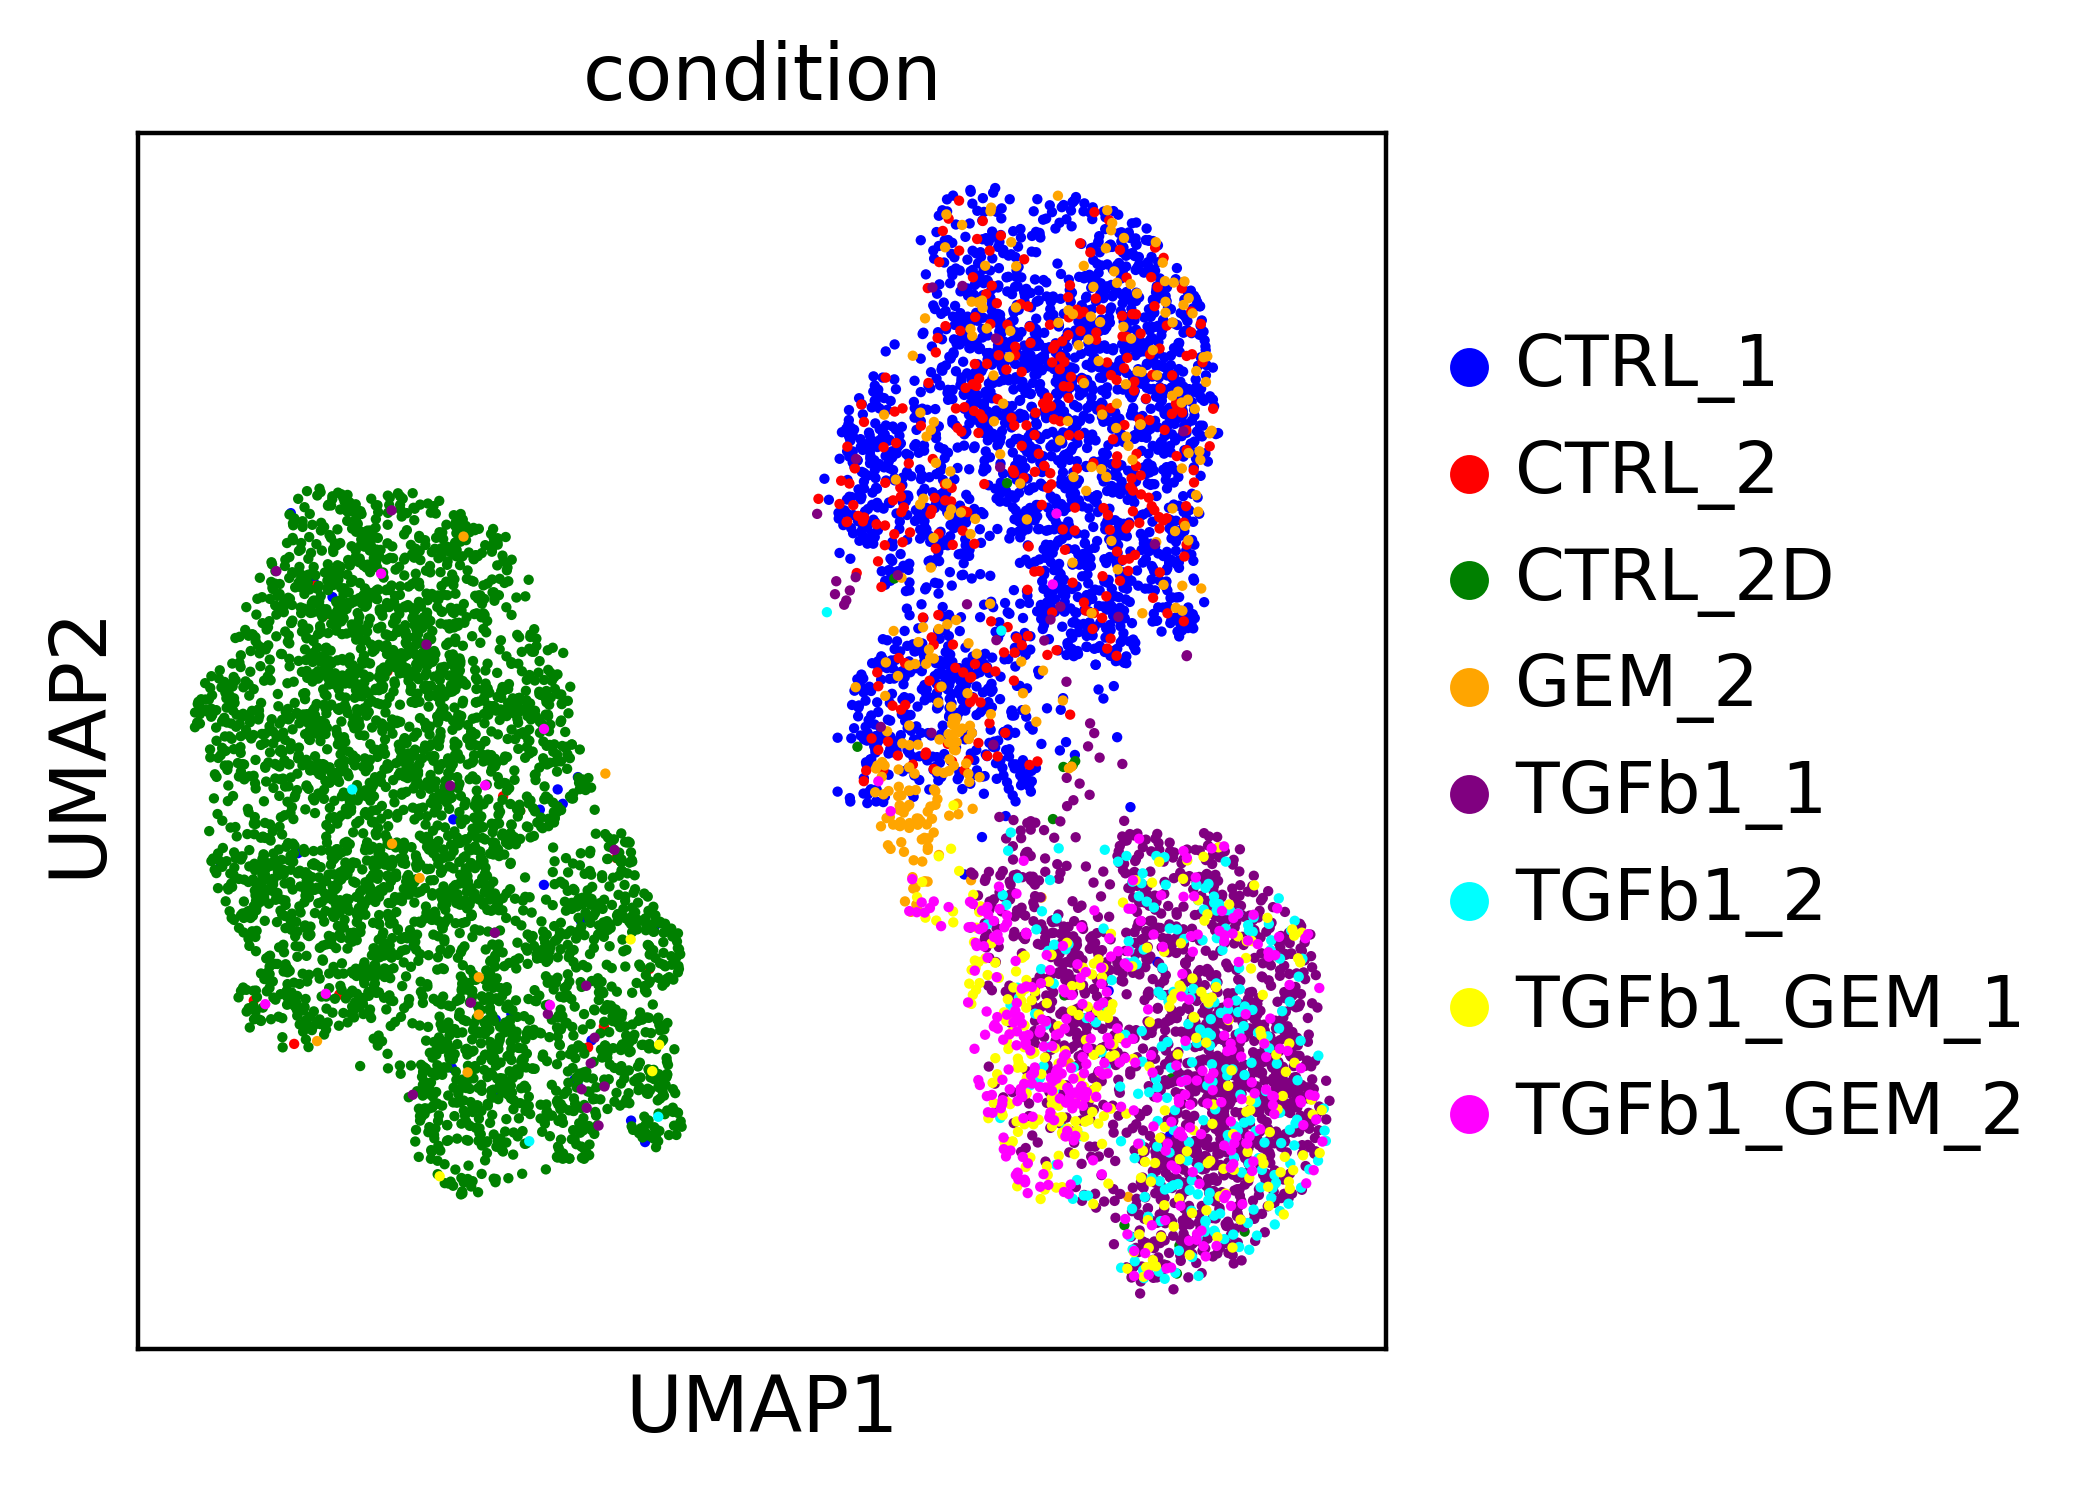

In [8]:
# Predefined condition-to-color mapping
condition_colors = {
    'CTRL_1': 'blue',
    'CTRL_2': 'red',
    'CTRL_2D': 'green',
    'GEM_2': 'orange',
    'TGFb1_1': 'purple',
    'TGFb1_2': 'cyan',
    'TGFb1_GEM_1': 'yellow',
    'TGFb1_GEM_2': 'magenta'
}

# Ensure all conditions in adata.obs['condition'] have a color mapping
conditions = adata.obs['condition'].unique()
missing_conditions = set(conditions) - set(condition_colors.keys())
if missing_conditions:
    raise ValueError(f"Color mapping missing for conditions: {missing_conditions}")

# Plot the UMAP with the predefined colors
sc.settings.set_figure_params(dpi=200, dpi_save=300)
sc.pl.umap(
    adata,
    color=['condition'],
    legend_loc='right margin',
    palette=condition_colors,
    save="_UMAP_cond_preprocessing.png"
)


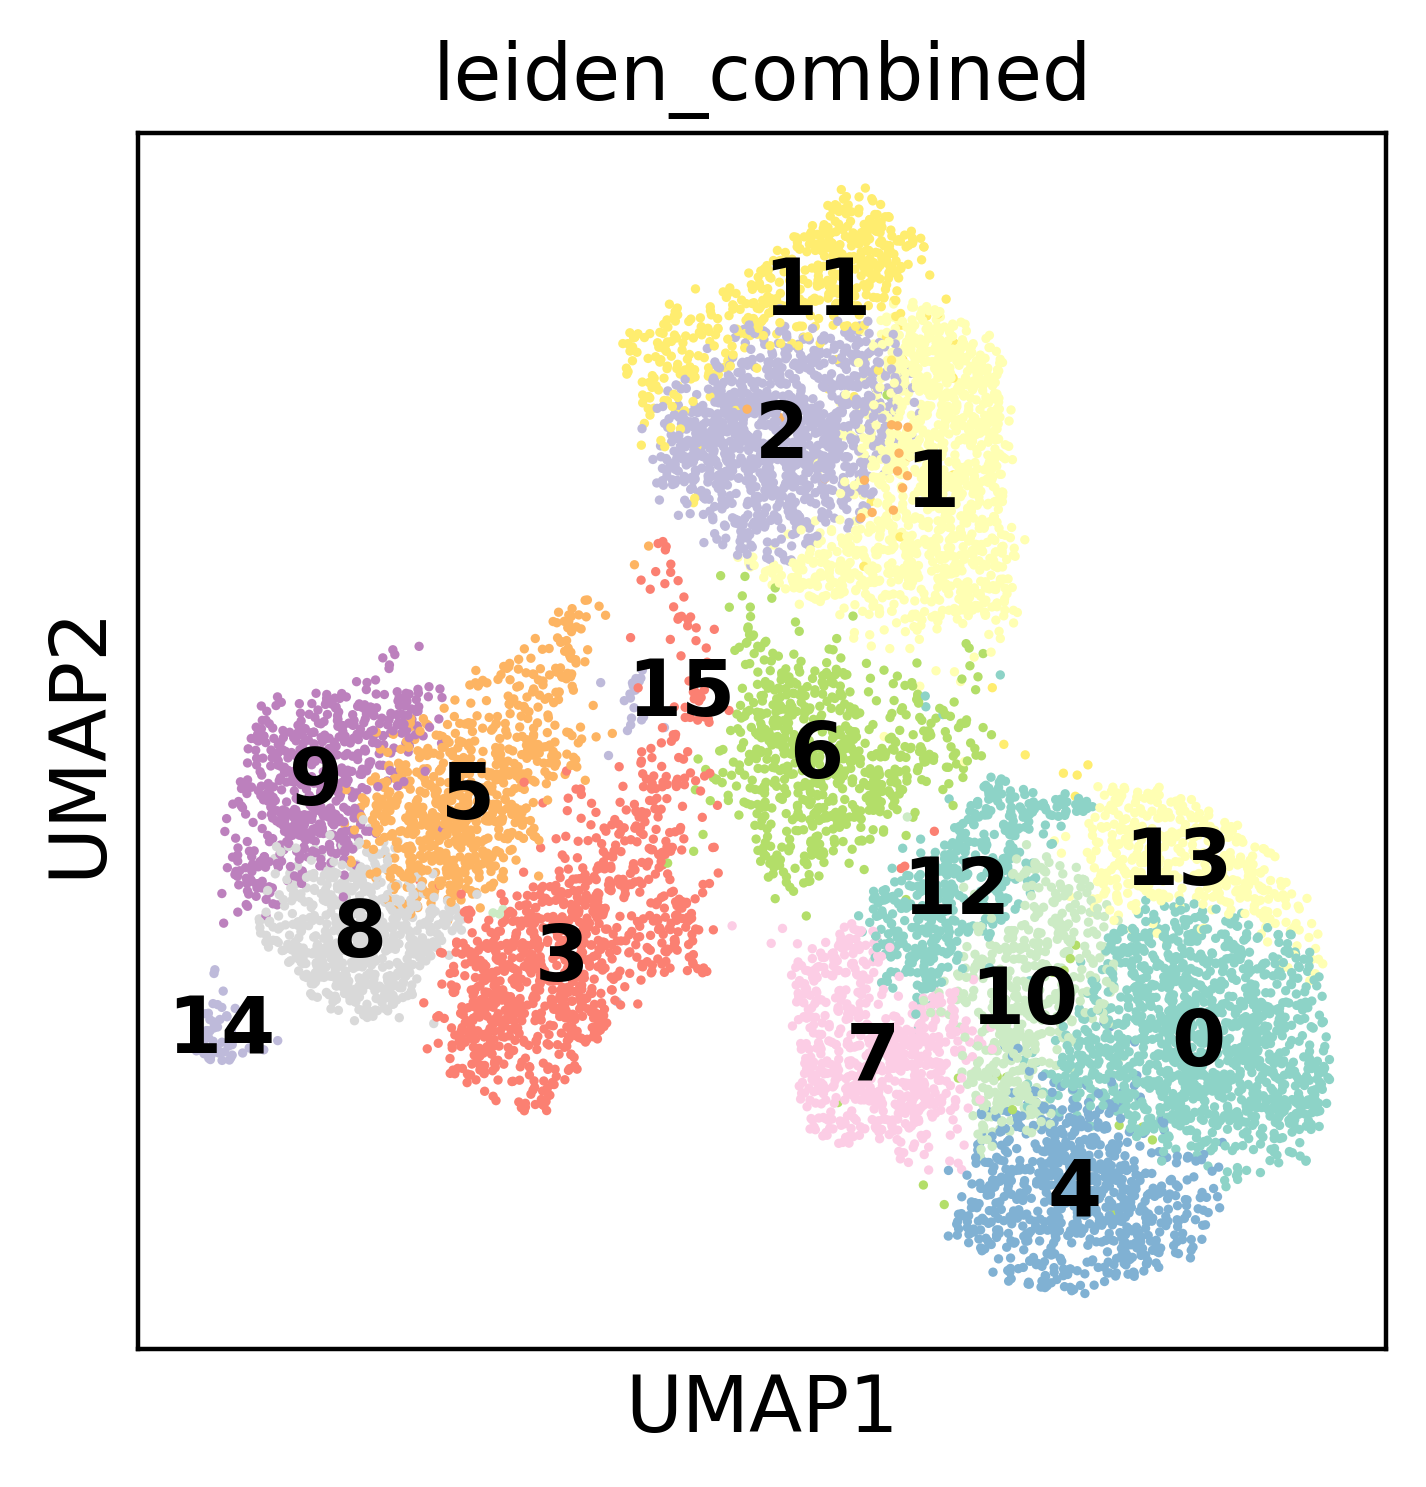

In [14]:
# Initialize variables
found = False
max_resolution = 1.0  # Maximum resolution to try
step_size = 0.02      # Step size for resolution
max_iterations = int(max_resolution / step_size)  # Calculate maximum iterations

# Iterate through Leiden resolutions to find 7 clusters
for i in range(max_iterations):
    resolution = step_size * (i + 1)  # Compute resolution
    sc.tl.leiden(adata, resolution=resolution)  # Perform Leiden clustering
    n_clusters = adata.obs['leiden'].nunique()  # Count unique clusters

    if n_clusters == 6:
        print(f"Found 6 clusters with resolution: {resolution}")
        found = True
        break  # Stop iteration once the desired number of clusters is found

# Stop condition handling
if not found:
    print(f"Could not find 6 clusters within resolution up to {max_resolution}.")
else:
    # Define a color palette for the clusters
    leiden_clusters = adata.obs['leiden']
    color_palette = sns.color_palette('Set3', n_clusters)

    # Visualize the UMAP with Leiden clustering
    sc.pl.umap(
        adata,
        color='leiden',
        palette=color_palette,
        legend_loc='on data',
        save=f"_UMAP_leiden_{resolution:.2f}_clusters.png"
    )


## Export

In [151]:
adata.write("/storage/users/data/PANC/H5AD_file/adata_filtered_clust.h5ad")